# TODO:
This seems to work pretty well. We may want to retrain the the LSTM with more hidden units. I've saved the current model.

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import json

In [49]:
tracks = json.load(open("../data/groundtruth_tracks.json"))

In [72]:
rmse = np.array([5.7930372, 3.9513907, 3.7556391, 3.8935025, 3.1221650, 3.5124706, 3.8339079, 3.4794855,
       2.9303418, 3.2985787, 5.4267551, 3.5405702, 3.4878588, 3.5515010, 3.9138511, 3.8537341, 
        3.2868891, 4.0449222, 3.1908154, 3.4649720, 4.8043567])
counts = np.array([243, 2681, 1032, 363, 818, 1275, 550, 2258, 1046, 2859, 603, 3405,55,
                  144, 455, 899, 836, 0, 1354, 927, 5497])

In [76]:
weights = sum(counts) - counts
mse = rmse**2
print np.mean(mse)
print sum(mse * weights) / sum(weights)

15.0553737701
15.0510633932


In [61]:
counts = {}
for k, t in tracks.items():
    key = k[:8]
    if key not in counts.keys():
        counts[key] = 0
    counts[key] += len(t)
print counts

{u'0019.txt': 927, u'0016.txt': 836, u'0018.txt': 1354, u'0011.txt': 3405, u'0005.txt': 1275, u'0010.txt': 603, u'0006.txt': 550, u'0003.txt': 363, u'0002.txt': 1032, u'0020.txt': 5497, u'0015.txt': 899, u'0004.txt': 818, u'0009.txt': 2859, u'0008.txt': 1046, u'0007.txt': 2258, u'0000.txt': 243, u'0012.txt': 144, u'0013.txt': 55, u'0014.txt': 455, u'0001.txt': 2681}


In [52]:
keys = set()
for key in tracks.keys():
    keys.add(key[0:8])
print len(keys)

20


In [24]:
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using Theano backend.


In [53]:
def buildLookbackDataset(tracks, lookback=3, skip=None):
    lookback +=1
    dataset = []
    for key, track in tracks.items():
        if skip:
            filename = "%04d.txt" % skip
            if filename in key:
                continue
        for i, pos in enumerate(track):
            if i < lookback:
                continue
            dataset.append(np.array(track[i-lookback:i]).ravel())
    return dataset
                
dataset = buildLookbackDataset(tracks) 
dataset = np.array(dataset)
# each row in the dataset is the x1, x2, y1, y2 
# where x1, x2 are the coordinate of previous position and y1,y2 are 
# coordinates of the next position or the location that should be predicted

In [56]:
dataset = buildLookbackDataset(tracks) 
dataset = np.array(dataset)
print dataset.shape
for i in xrange(21):
    dataset = buildLookbackDataset(tracks, skip=i) 
    dataset = np.array(dataset)
    print dataset.shape

(25002, 8)
(25002, 8)
(22677, 8)
(24029, 8)
(24671, 8)
(24284, 8)
(23859, 8)
(24496, 8)
(22956, 8)
(24039, 8)
(22463, 8)
(24451, 8)
(21803, 8)
(24866, 8)
(24955, 8)
(24603, 8)
(24139, 8)
(24182, 8)
(25002, 8)
(23720, 8)
(24103, 8)
(19947, 8)


In [31]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [32]:
# Split into test and train
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

(16751, 8251)


In [33]:
xtrain = np.matrix(train[:,0:6])
ytrain = np.matrix(train[:,6:])
xtest = np.matrix(test[:,0:6])
ytest = np.matrix(test[:,6:])

In [34]:
# reshape input to be [samples, time steps, features]
xtrain = np.reshape(np.array(xtrain), (xtrain.shape[0], 3, 2))
xtest = np.reshape(np.array(xtest), (xtest.shape[0], 3, 2))

In [35]:
xtrain[0].shape


(3, 2)

In [123]:

model = Sequential()
model.add(LSTM(32, input_shape=(3,2)))
model.add(Dense(2))
model.compile(loss='mean_squared_error', optimizer='adam')
if True:
    model.fit(xtrain, ytrain, nb_epoch=10, batch_size=1, verbose=2)
else:
    model.load_weights('window3_weights.h5')


Epoch 1/10
22s - loss: 8.4490e-04
Epoch 2/10
31s - loss: 1.2574e-04
Epoch 3/10
29s - loss: 9.4804e-05
Epoch 4/10
27s - loss: 8.7904e-05
Epoch 5/10
25s - loss: 8.2156e-05
Epoch 6/10
25s - loss: 7.9009e-05
Epoch 7/10
27s - loss: 7.5314e-05
Epoch 8/10
30s - loss: 7.3245e-05
Epoch 9/10
22s - loss: 7.0216e-05
Epoch 10/10
22s - loss: 6.8170e-05


In [124]:
trainPredict = model.predict(xtrain)
testPredict = model.predict(xtest)
# invert predictions
#trainPredict = scaler.inverse_transform(np.concatenate((xtrain.reshape(xtrain.shape[0], xtrain.shape[2]),trainPredict), axis=1))[:,2:]
#trainY = scaler.inverse_transform([trainY])
#testPredict = scaler.inverse_transform(testPredict)
#testY = scaler.inverse_transform([testY])
# calculate root mean squared error

trainScore = math.sqrt(mean_squared_error(ytrain, trainPredict))
print('Train Score: %.7f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(ytest, testPredict))
print('Test Score: %.7f RMSE' % (testScore))

Train Score: 0.0072513 RMSE
Test Score: 0.0064826 RMSE


In [125]:
scaledPredictTrain = scaler.inverse_transform(np.concatenate((ytrain,trainPredict,ytrain,trainPredict), axis=1))
scaledPredictTest = scaler.inverse_transform(np.concatenate((ytest,testPredict,ytest,testPredict), axis=1))
scaledyTrain = scaler.inverse_transform(np.concatenate((ytrain,trainPredict,ytrain,ytrain), axis=1))
scaledyTest = scaler.inverse_transform(np.concatenate((ytest,testPredict,ytest,ytest), axis=1))

trainScore = math.sqrt(mean_squared_error(scaledyTrain[:,6:], scaledPredictTrain[:,6:]))
print('Train Score: %.7f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(scaledyTest[:,6:], scaledPredictTest[:,6:]))
print('Test Score: %.7f RMSE' % (testScore))

print ytrain.shape

Train Score: 4.0492031 RMSE
Test Score: 3.6793558 RMSE
(16751, 2)


In [126]:
#print model.predict(np.array(tracks.items()[0][1][0]).reshape(1,1,2))
print tracks.items()[0][1][0]
print tracks.items()[0][1][1]

[777.654416, 165.681078]
[781.156791, 165.186175]


In [127]:
print np.array(tracks.items()[0][1][0]+tracks.items()[0][1][1]+tracks.items()[0][1][2]\
               +tracks.items()[0][1][3]).reshape(1,-1)
orig_scale=np.array(tracks.items()[0][1][0]+tracks.items()[0][1][1]+tracks.items()[0][1][2]\
               +tracks.items()[0][1][3]).reshape(1,-1)
l = scaler.transform(orig_scale)
print l
#x = l[0:2].reshape(1,1,2)
#y = l[2:]

[[ 777.654416   165.681078   781.156791   165.186175   784.809185
   164.670002   788.6214485  164.131158 ]]
[[ 0.62446123  0.09930999  0.62646688  0.09784558  0.62939047  0.09337126
   0.63313688  0.09231694]]


In [128]:
# Note this will predict the new point one frame ahead and build a track by 
# using measurements from the previous measurement.
# The first prediction is exactly the first measurement
# The last prediction is emitted because we know that the object is gone
# but currently the model has no method for predicting the death of an object
def rebuildTracks(tracks, model):
    predTracks = {}
    for track in tracks.items():
        predTracks[track[0]] = []
        t = predTracks[track[0]]
        for i, pos in enumerate(track[1]):
            if i < 3:
                t.append(pos)
            else:
                # scale and resize
                p1 = track[1][i-3]
                p2 = track[1][i-2]
                p3 = track[1][i-1]
                p = scaler.transform(np.array(p1+p2+p3+p3).reshape(1,-1))[0][0:6].reshape(1,3,2)
                # predict
                pred = model.predict(p).reshape(1,2).tolist()
                pred = scaler.inverse_transform(np.array(pred[0]+pred[0]+pred[0]+pred[0])\
                                                .reshape(1,-1))[0][6:]
                t.append(pred)
    return predTracks

In [129]:
predictedTracks = rebuildTracks(tracks,model)

In [130]:
def displayPredictedTracks(tracks,predictedTracks, k):
    for i in np.random.choice(len(tracks.items()), k):
        if i / float(len(tracks.items())) < .67:
            print "Training"
        else:
            print "Testing"
        print "%d of %d"% (i, len(tracks.items()))
        key = tracks.items()[i][0]
        track = np.array(tracks.items()[i][1])
        t2 = np.array(predictedTracks[key])
        plt.plot(track[0,0], -track[0,1], marker="x")
        plt.plot(track[:,0], -track[:,1], marker="o", color='b')
        plt.plot(t2[:,0], -t2[:,1], marker="s", color='r')


Training
130 of 579


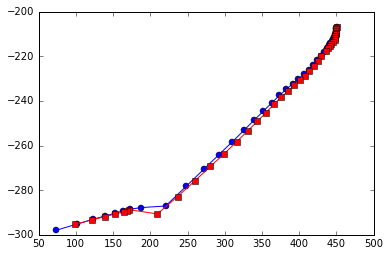

In [144]:
displayPredictedTracks(tracks,predictedTracks, 1)

In [145]:
#model.save_weights('window3_32h_weights.h5')

In [108]:
#scaler.get_params()

dict

In [109]:
#import pickle

In [110]:
#with open('scaler.pickle', 'wb') as handle:
#    pickle.dump(scaler, handle)

In [49]:
def covariance(tracks, predTracks):
    x = []
    y = []
    for (key, track) in tracks.items():
        for j, point in enumerate(track):
            x.append(point[0] - predictedTracks[key][j][0])
            y.append(point[1] - predictedTracks[key][j][1])
    x = np.matrix(x)
    y = np.matrix(y)
    m = np.concatenate((x,y), axis=0)
    print np.var(x)
    print np.var(y)
    return np.cov(m)

In [50]:
print covariance(tracks, predictedTracks)

28.0064938099
2.72131484714
[[ 28.00751973  -0.93562177]
 [ -0.93562177   2.72141453]]
